In [5]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
from struct import unpack
import os
import shutil

In [6]:
## images path
orig_path = pathlib.Path(r'C:\Users\istra\img\images\images')
destin_path= pathlib.Path(r'C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers')
image_count=len(list(orig_path.glob('*.jpg')))
print(image_count)

53618


-------------------------------
Opening the csv file

In [7]:
goodread = pd.read_csv(r'C:\Users\istra\img\book_data.csv')

-----------------
Splitting the genres column

In [8]:
all_genres = [ str(genres).split("|") for genres in goodread["genres"]]

In [9]:
all_genres_long =pd.DataFrame([genre for book in all_genres for genre in book])

In [10]:
all_genres_long.columns = ("genre",)

Plotting the main genres we see in all tags > 800

<AxesSubplot:xlabel='genre'>

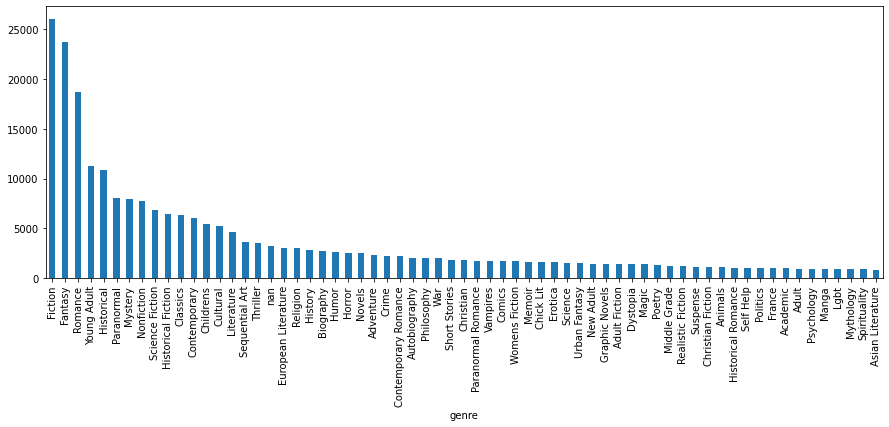

In [184]:
all_genres_long.value_counts("genre")[all_genres_long.value_counts("genre")>800 ].plot.bar(figsize=(15,5))

---------------------
Analysis of the genres in Nonfiction

In [185]:
listna =goodread["genres"].str.contains('Nonfiction')
listna[listna.isna()] = False
nonfiction_books = goodread[listna]

<AxesSubplot:xlabel='0'>

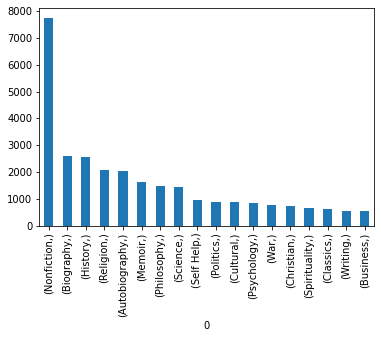

In [183]:
nonfiction = pd.DataFrame(all_genres)[listna]
l=[]
i=0
while i<len(nonfiction):
    j=0
    while j<17:
        l.append(nonfiction.iloc[i,j])
        j+=1
    i+=1
pd.DataFrame(l).value_counts()[pd.DataFrame(l).value_counts()>500].plot.bar()

Parmi non fiction on regroupe : 
 - Biography + Autobiography + Memoir
 - Philosophy + Spirituality + Religion + Christian 
 - History + Politics + War 

-------------------------------
Doing the same analysis for the first, second and thrid tag

In [15]:
genre_tags = pd.DataFrame(all_genres).iloc[:,0:3]
genre_tags.columns = ("first","second","third")

<AxesSubplot:xlabel='third'>

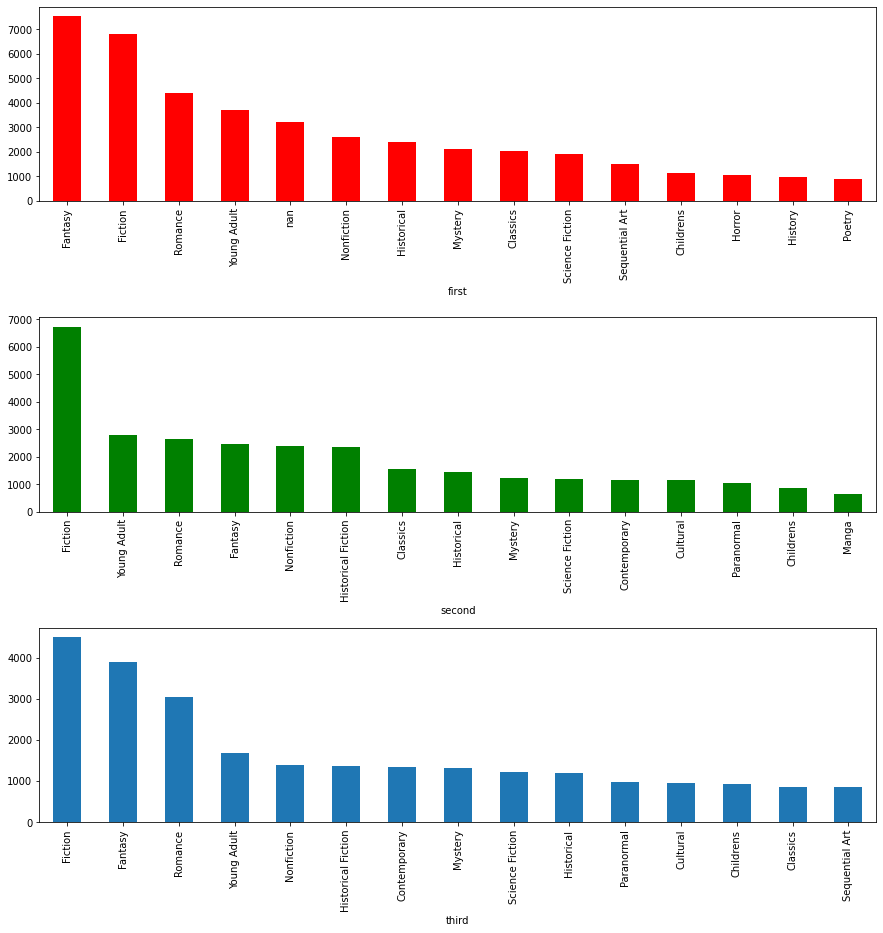

In [16]:
fig,axes  = plt.subplots(nrows = 3 , ncols =1, figsize=(15,15))
fig.subplots_adjust(hspace=0.6)
genre_tags.value_counts("first")[:15].plot.bar(ax=axes[0],color="red")
genre_tags.value_counts("second")[:15].plot.bar(ax=axes[1],color="green")
genre_tags.value_counts("third")[:15].plot.bar(ax=axes[2])

---------------------
Because there is a lot of overlapping between genres, mont books having multiple tags, we will take on the first tag that is from  the following categories : 

['Fantasy','Romance', 'Young Adult', 'Historical', 'Mystery', 'Science Fiction', 'Sequential Art', 'History', 'Childrens', 'Horror', 'Poetry', 'War','Politics','Christian','Spirituality','Religion','Philosophy','Memoir','Autobiography','Biography']

In [144]:
glist = ['Fantasy','Romance', 'Young Adult', 'Historical', 'Mystery', 'Science Fiction', 'Sequential Art', 'History', 'Childrens', 'Horror', 'Poetry', 'War','Politics','Christian','Spirituality','Religion','Philosophy','Memoir','Autobiography','Biography']

genres = pd.DataFrame([next((genre for genre in book if genre in glist),None) for book in all_genres],columns =("genre",))

All Books that are ommited from the analysis 

In [178]:
genres["genre"].isna().sum()

10727

In [188]:
final_genres = goodread.drop(goodread.loc[:,"book_desc":"book_review_count"].columns, axis=1).drop("image_url",axis=1)

In [189]:
final_genres["main_genre"] = genres
final_genres["img"] = final_genres.index.astype('str')+".jpg"

In [196]:
tags = pd.DataFrame(genres.value_counts("genre"), columns =("count",))
tags

,count
genre,
Fantasy,8732
Romance,6530
Young Adult,4543
Historical,4533
Mystery,3510
Science Fiction,2607
History,1726
Childrens,1687
Sequential Art,1587


<AxesSubplot:xlabel='genre'>

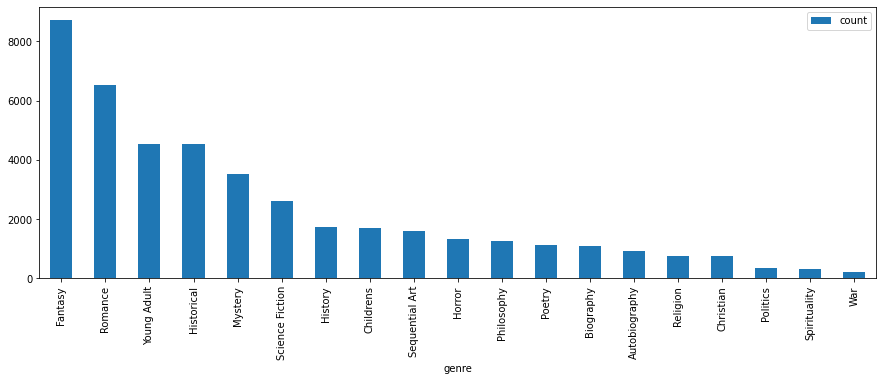

In [192]:
tags[tags["count"]>1].plot.bar(figsize=(15,5))

In [199]:
selected_categories = list(tags.index)
selected_categories

['Fantasy',
 'Romance',
 'Young Adult',
 'Historical',
 'Mystery',
 'Science Fiction',
 'History',
 'Childrens',
 'Sequential Art',
 'Horror',
 'Philosophy',
 'Poetry',
 'Biography',
 'Autobiography',
 'Religion',
 'Christian',
 'Politics',
 'Spirituality',
 'War']

--------------------
Mapping function to regroup some genres 

In [157]:
def return_label(mg):
      if mg in selected_categories:
        val=mg
        if mg in ("Autobiography",'Biography','Memoir') : val = "Biography"
        if mg in ("Spirituality",'Christian','Religion','Philosophy') : val = "Religion & Philosophy"
        if mg in ("Politics",'War','History') : val = "Politics & History"
    else:
        val = "Other"
    return val

In [208]:
final_genres_filtered = final_genres
final_genres_filtered["main_label"]=final_genres_filtered["main_genre"].map(return_label)
final_genres_filtered = final_genres_filtered[final_genres_filtered.main_label != "Other"]
final_genres_filtered = final_genres_filtered.drop("main_genre",axis=1)

<AxesSubplot:xlabel='main_label'>

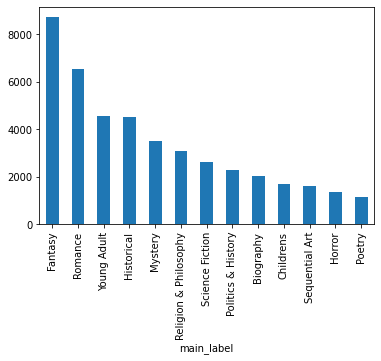

In [207]:
final_genres_filtered.value_counts("main_label").plot.bar()

In [209]:
%store final_genres_filtered

Stored 'final_genres_filtered' (DataFrame)


In [210]:
final_genres_filtered.to_csv("final_genres.csv")

-------------------------
Check & Copy the selected files in sub-folders by genre

In [159]:
def check_image(fn):
    try:
        fobj = open(fn, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        if not is_jfif: raise NameError('corrupt file')
        file_contents = tf.io.read_file(fn)
        image = tf.image.decode_jpeg(file_contents, channels=3)
    except:
        print("check error",fn)
        raise NameError('corrupt file')

In [ ]:
num_skipped = 0
num_copied = 0 
file_exists = 0
for index,book in final_genres_filtered.iterrows():
    genre = book["main_label"]
    fpath = str(orig_path) +"\\"+book["img"]
    target= str(destin_path)+"\\"+genre+"\\"+book["img"]
    if not os.path.exists(str(destin_path)+"\\"+genre): 
        os.mkdir(str(destin_path)+"\\"+genre)
    try:
        if os.path.isfile(target):
            file_exists+=1
        else:
            check_image(fpath)
    except:
        print("error, the following image was not copied",fpath)
        num_skipped+=1
    else:
        try:
            if not os.path.isfile(target):
                shutil.copy(fpath,target)
                num_copied +=1

        except IOError as e:
            print("Unable to copy file. %s" % e)
        except:
            print("Unexpected error:", sys.exc_info())
print("We skipped %d corrupt images" % num_skipped)
print("There were already %d files there" %file_exists)
print("We copied %d files" %num_copied)